In [1]:
!pip install scikeras scikit-learn-intelex threadpoolctl -q

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import os
# import re
# from __future__ import print_function
from datetime import datetime

# import string
# import spacy
# import nltk
# from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,GridSearchCV

import tensorflow as tf   
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.python.keras import Sequential
from keras.layers import Embedding, LSTM, Dense,Dropout
from scikeras.wrappers import  KerasClassifier
from sklearn.utils.class_weight import compute_class_weight
# from sklearn.pipeline import Pipeline
# from keras.utils import to_categorical

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, f1_score,precision_score, recall_score

# Load data

In [3]:
df = pd.read_csv('../data/processed/drug_review_clean.csv', index_col= False)

# Preprocess

# Build a class to do preprocess
The dataframe contains different types of features: numericals ('mean_word_len','word_count', etc), categorical(eg.'rating_category','condidition','drugName'), and datetime ('date'). Also, The target of 'sentiment_label' is categorimcal. The preprocess including the following steps:

1.tokenizer the'review_clean' using keras Tokenizer
2. encode the categorical features and target 'sentiment_label'
3. extract the 'date' to several new features 'year','month','day'.
4.scale the numerical features using MinMaxScaler.
5. train test split

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_sequence_length=214):
        self.max_sequence_length = max_sequence_length
        self.tokenizer = None
    """ define a function to convert text to tokenizer """
    def fit(self, X, y=None):
        self.tokenizer = Tokenizer(num_words = 5000, lower = False)
        self.tokenizer.fit_on_texts(X)
        return self
    """ define a function to convert the review text into sequence """

    def transform(self, X):
        sequences = self.tokenizer.texts_to_sequences(X)
        return pad_sequences(sequences, maxlen= 200)


In [5]:
class NumericalScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.scaler = MinMaxScaler()
        self.scaler.fit(X)
        return self

    def transform(self, X):
        return self.scaler.transform(X)

In [6]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ordinal_encoder = OrdinalEncoder()
        
    def fit(self, X, y = None):
        
        self.ordinal_encoder.fit(X)
        return self

    def transform(self,X):
        return self.ordinal_encoder.transform(X)

In [7]:
class DateExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self,X):
        X['date'] = pd.to_datetime(X['date'])
        X['year'] = X['date'].dt.year
        X['month'] = X['date'].dt.month
        X['day'] = X['date'].dt.day
        return X[['year','month','day']]             

In [8]:
X = df[
    [
        "drugName",
        "condition",
        "rating",
        "date",
        "usefulCount",
        "rating_category",
        "review_clean",
        "review_len",
        "mean_sentence_len",
        "word_count",
        "mean_word_len",
        "unique_word_count",
        "sentiment_subjectivity",
        "sentiment_score",
        "genuine_positive",
        "genuine_negative",
        "genuine_neutral",
    ]
]
y = df[["sentiment_label"]]

In [9]:
# Transfrom each feature
df["review_clean"] = df["review_clean"].apply(lambda x: " ".join(x.split()[:200]))
X_text = TextPreprocessor(max_sequence_length=214).fit_transform(df["review_clean"])
numerical_cols = [
    "rating",
    "usefulCount",
    "review_len",
    "mean_sentence_len",
    "word_count",
    "mean_word_len",
    "unique_word_count",
    "sentiment_subjectivity",
    "sentiment_score",
]
X_numerical = NumericalScaler().fit_transform(df[numerical_cols])
X_drugName = CategoricalEncoder().fit_transform(df[["drugName"]])
X_condition = CategoricalEncoder().fit_transform(df[["condition"]])
X_date = DateExtractor().fit_transform(df)

In [10]:
#combine the features
X_transformed = np.concatenate([X_text, X_numerical, X_drugName,
                                X_condition, X_date], axis=1)

In [11]:
#encode targe feature
sentiment_label_encode = LabelEncoder()
y_encode = sentiment_label_encode.fit_transform(df['sentiment_label'])


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y_encode, test_size=0.25, random_state=123
)

In [13]:
from sklearn.utils.class_weight import compute_class_weight
unique_labels= np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=unique_labels, y=y_train)
class_weight_dict = dict(zip(unique_labels, class_weights))
for label, weight in class_weight_dict.items():
    print(f'Class:{label}, weight:{weight:.2f}')

Class:0, weight:1.26
Class:1, weight:3.15
Class:2, weight:0.53


There weight for postive sentiment (class1) is 3.15, for negtive is 0.53(class 2) and for neutral is 1.26(class 0). This imbalance will be addressed during modeling.

# Modeling


The objective of the model is to predict sentiment accurately while mitigating bias. The dataset is imbalanced with more positive sentiments. Employing accuracy as the primary metric may lead to misleading conclusions. To avoid this.  The F1 score will serve as the principal metric. Meanwhile, metrics such as training time, precision, recall and accuracy scale for each model will be recorded. The chosen model will ideally strike a balance between predictive performance, computational efficiency and the ability to capture sentiment in drug review.


Three models will be explored in this sentiment analysis task:
1. Multinomial Naive Bayes(MNB) it is a probabilistic classification algorithm based on Bayes theorem and it is widely used in processing text data. it assumes independence between features. the simplicity and efficiency make it a great baseline model for text based sentiment analysis taks.
2. Long short term memory(LSTM) This is a type of recurrent neural network RNN designed for sequential data processing. For sentiment analysis, LSTM excels in capturing dependencies and nuances in text information over extended sequences. Its ability to retain and forget information makes it well suited for tasks where context plays a crucial role, e.g underlying sentiment in long text.
3. Random Forest (RF) It is an effective ensemble learning method in classification. It can provide feature importances, which can help extend the understanding of the model process.


## Model Metrics Comparision

build a method to evaluate model performance

In [14]:
metrics_list =[]
pd.DataFrame(columns = ['model', 'accuracy', 'precision','recall','F1 score'])

def model_metrics(model, y_true, y_pred, best_params = None):
    f1 = f1_score(y_true, y_pred, average="macro")
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    print(f"\n model performance:")
    if best_params:
        print(f"Best hyperparameters: {best_params}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")


    
    metrics_list.append({'model': model,
                                'accuracy':accuracy,
                                'precision': precision,
                                'recall': recall,
                                'F1-score':f1,
                                })

    print(f'\n {model} Classification Report:')
    print(classification_report(y_true, y_pred))
   
    """plot comfusion matrix"""
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        xticklabels=["class 0 neutral", "class 1 positive", "class 2 negative"],
        yticklabels=["class 0", "class 1", "class 2"],
    )
    plt.xlabel("predicted Labels")
    plt.ylabel("actual labels")
    plt.title(f"confusion matrix ")
    plt.show()

    

## Multinomial Naive Bayes Model (MNB)

In [15]:
mnb_model = MultinomialNB()
mnb_param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
          'fit_prior': [True, False]
         }
mnb_grid = RandomizedSearchCV(mnb_model, param_distributions=mnb_param_grid, n_jobs=-1, cv=5, verbose=1)

print("MNB Start Time", datetime.now().strftime("%H:%M:%S"))
mnb_grid.fit(X_train,y_train)
print("MNB End Time =", datetime.now().strftime("%H:%M:%S"))


MNB Start Time 21:54:47
Fitting 5 folds for each of 10 candidates, totalling 50 fits
MNB End Time = 21:54:53


MNB shows a fast training time.

In [16]:
best_mnb_params = mnb_grid.best_params_
y_mnb_pred = mnb_grid.best_estimator_.predict(X_test)


 model performance:
Best hyperparameters: {'fit_prior': True, 'alpha': 10.0}
Accuracy: 0.3688
Precision: 0.3993
Recall: 0.4997
F1-score: 0.3512

 MultinomialNB(alpha=10.0) Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.27      0.28      8321
           1       0.21      0.91      0.33      3384
           2       0.70      0.32      0.44     20292

    accuracy                           0.37     31997
   macro avg       0.40      0.50      0.35     31997
weighted avg       0.54      0.37      0.39     31997



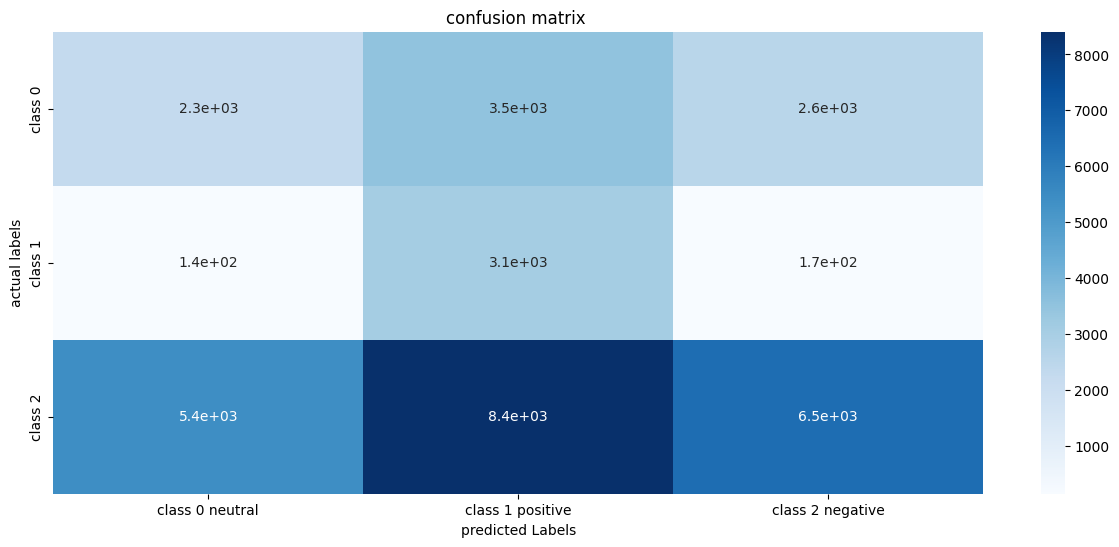

In [17]:
model_metrics(mnb_grid.best_estimator_, y_test, y_mnb_pred, best_mnb_params)

## Random Forest Model

Start Time = 21:54:54
Fitting 2 folds for each of 24 candidates, totalling 48 fits


C:\ProgramData\anaconda3\envs\Capstone_Three_Project\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


End Time = 21:56:38

 model performance:
Best hyperparameters: {'n_estimators': 25, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 5}
Accuracy: 0.9973
Precision: 0.9918
Recall: 0.9983
F1-score: 0.9950

 RandomForestClassifier(max_depth=5, max_features=None, min_samples_leaf=4,
                       n_estimators=25) Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8321
           1       0.98      1.00      0.99      3384
           2       1.00      1.00      1.00     20292

    accuracy                           1.00     31997
   macro avg       0.99      1.00      1.00     31997
weighted avg       1.00      1.00      1.00     31997



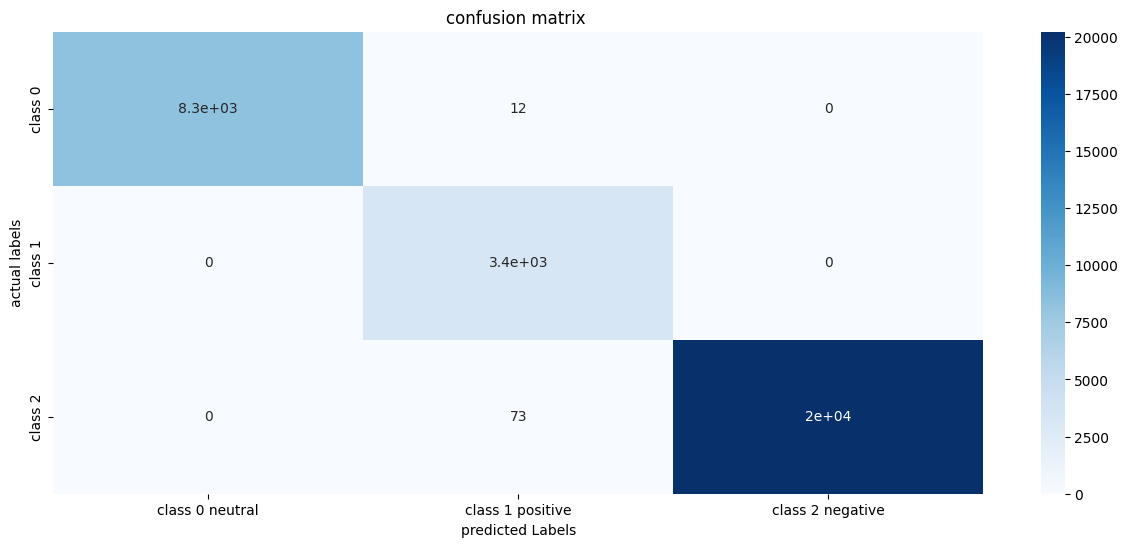

In [18]:
rf =  RandomForestClassifier()
random_grid = {
               'max_depth': [5, 10],
               'max_features': ['log2','sqrt', None],
               'min_samples_leaf': [4, 8],
               'n_estimators': [25, 50]}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)

from datetime import datetime
print("Start Time =", datetime.now().strftime("%H:%M:%S"))
rf_random_result = rf_random.fit(
    X_train, y_train
)
print("End Time =", datetime.now().strftime("%H:%M:%S"))


best_rf_params = rf_random.best_params_
best_rf_model = rf_random.best_estimator_

y_rf_pred = best_rf_model.predict(X_test).round() 
model_metrics(best_rf_model, y_test, y_rf_pred, best_rf_params)

## LSTM model

In [19]:
# build a LSTM sequential model
def create_lstm_model(dropout_rate=0, epochs=5, batch_size=32):
    lstm_model = tf.keras.models.Sequential()
    lstm_model.add(Embedding(input_dim=5000, output_dim=32, input_length=214))
    lstm_model.add(LSTM(100))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(3, activation="softmax"))
    lstm_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    lstm_model.summary()
    return lstm_model

In [20]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
lstm_model = KerasClassifier(
    model=create_lstm_model, dropout_rate=None, epochs=1, batch_size=None, verbose=1
)

In [21]:
#hyperameter tunning
param_grids = {
    'dropout_rate': [0.0, 0.2],
    'epochs': [5,10],
    'batch_size': [32, 64],
    'class_weight': [class_weight_dict]
}

In [22]:
from sklearn.metrics import make_scorer
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=123)
#model metrics
scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }

lstm_grid = RandomizedSearchCV(
    estimator=lstm_model,
    param_distributions=param_grids,
    cv=kfold,
    scoring = scorers,
    verbose=1, error_score='raise',n_jobs=-1, refit='f1_score'
)

In [23]:
from datetime import datetime
print("Start Time =", datetime.now().strftime("%H:%M:%S"))
lstm_grid_result = lstm_grid.fit(
    X_train, y_train, batch_size=None,
    epochs=3,
    verbose=1,
   
)
print("End Time =", datetime.now().strftime("%H:%M:%S"))

Start Time = 21:56:39
Fitting 2 folds for each of 8 candidates, totalling 16 fits


C:\ProgramData\anaconda3\envs\Capstone_Three_Project\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\ProgramData\anaconda3\envs\Capstone_Three_Project\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 214, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 213503 (834.00 KB)
Trainable params: 213503 (834.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3


3000/3000 [==============================] - 243s 80ms/step - loss: 0.4652 - accuracy: 0.7459
Epoch 2/3
3000/3000 [===================

500/500 [==============================] - 24s 47ms/step

 model performance:
Best hyperparameters: {'epochs': 5, 'dropout_rate': 0.0, 'class_weight': {0: 1.261499237764811, 1: 3.1545565085937755, 2: 0.529019173431653}, 'batch_size': 64}
Accuracy: 0.9293
Precision: 0.9198
Recall: 0.9459
F1-score: 0.9295

 KerasClassifier(
	model=<function create_lstm_model at 0x000001ECED63A5C0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=5
	dropout_rate=0.0
	class_weight={0: 1.261499237764811, 1: 3.1545565085937755, 2: 0.529019173431653}
) Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.88      8321
           1       0.96      0.96      0.96      3384
           2       0.99      0.91      0.95     20292

    accuracy                           0.93 

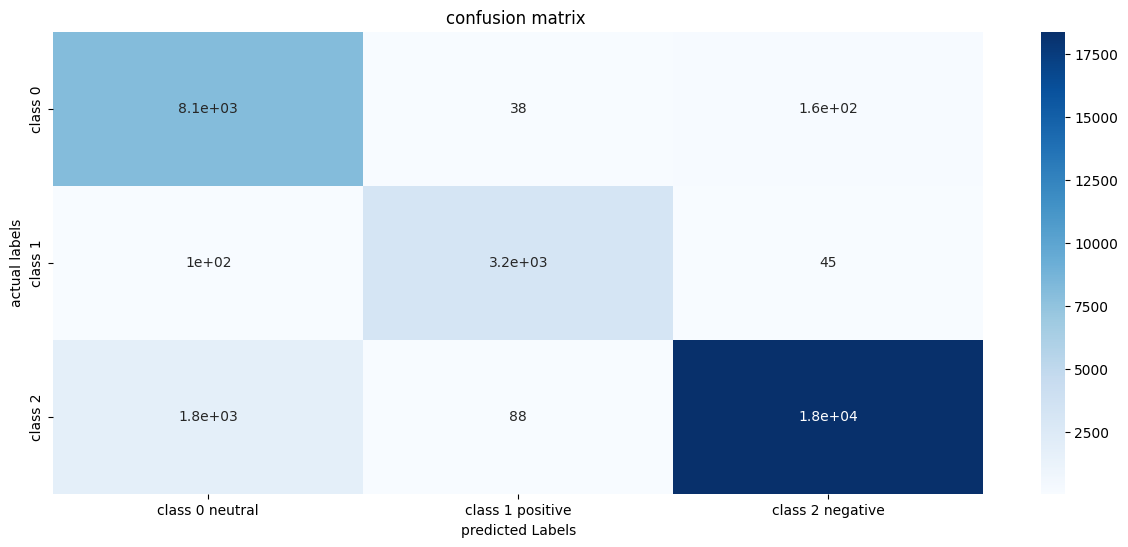

In [24]:
best_lstm_params = lstm_grid.best_params_
best_lstm_model = lstm_grid.best_estimator_
y_lstm_pred = best_lstm_model.predict(X_test)
model_metrics(best_lstm_model, y_test, y_lstm_pred, best_lstm_params)

# Save The Best Model

In [25]:
import joblib

The RandomForest model is the top performing model with F1 score of 0.99 and a fast training time.

In [29]:
# save the model
joblib.dump(best_rf_model, '../models/best_rf_model.joblib')

load_model = joblib.load('../models/best_rf_model.joblib')

# Summary

To build a drug sentiment analysis model, the following preprocessing and model steps were performed:
1. Text Tokenization: the 'review' text column was tokenized to break down sentences into individual words for analysis. To avoid overfit and reduce training time, only the first 200 words in each review column were used.
2. Categorical features ('drugName','condition') encoding. One hot encoding was applied and converted them into a suitable format for modeling.
3. Date feature extraction: 'date', 'year','month' were extracted from the 'date';
4. Sentiment encoding: the target feature sentiment was encoded and three sentiment classes were created.
5. Numerical featuring scaling: using MinMaxScaler to standardize the range of values.
4. Train_test split: The dataset was split into train (0.75), and test(0.25).
5. Model exploration: Three models were explored (Multinomial Naive Bayes(MNB), Long Short-Term Memory (LSTM), and Random Forest(RF))
6. Model Evaluation: The tuning model performances were assessed. RandomForest emerged as the top performing model with F1 scores reaching over 0.99, and with moderate training time (2.5 minutes).
